Exercise: _Tackle the Titanic dataset. A great place to start is on [Kaggle](https://www.kaggle.com/c/titanic). Alternatively, you can download the data from https://homl.info/titanic.tgz and unzip this tarball like you did for the housing data in Chapter 2. This will give you two CSV files: _train.csv_ and _test.csv_ which you can load using `pandas.read_csv()`. The goal is to train a classifier that can predict the `Survived` column based on the other columns._

In [767]:
from pathlib import Path
import tarfile
import pandas as pd
import urllib.request

def fetch_and_load_data():
    tar_path=Path("data/titanic.tgz")
    Path("data").mkdir(parents=False, exist_ok=True)
    url = "https://github.com/ageron/data/raw/main/titanic.tgz"
    urllib.request.urlretrieve(url, tar_path)
    with tarfile.open(tar_path) as tf:
        tf.extractall(path="data")
    return pd.read_csv(Path("data/titanic/train.csv")), pd.read_csv(Path("data/titanic/test.csv"))

In [768]:
train_set, test_set = fetch_and_load_data()

In [769]:
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [770]:
test_set.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [771]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The attributes have the following meaning:
* **PassengerId**: a unique identifier for each passenger
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.

So, we see that the `Age`, `Cabin` and `Embarked` attributes have null values. Primarily, the `Cabin` usually is always null. Therefore, it is reasonable to ignore that attribute for now. Remains `Age` and `Embarked`. The first thing we can do with age is to fill it with the median. If we want to be a little wiser, we can predict median age using other attributes (for example, using `Pclass`), but we will stay with a simple median. Apart from that, `Name` and `Ticket` attributes are probably useless. Each passenger has a different name and ticket id.

In [772]:
train_set.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [773]:
train_set["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [774]:
train_set["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [775]:
train_set["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [776]:
train_set["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Let's explicitly set the `PassengerId` as the index.

In [777]:
train_set = train_set.set_index("PassengerId")
test_set = test_set.set_index("PassengerId")

Let's see correlations.

In [778]:
corr_matrix = train_set.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.077221
Pclass     -0.338481
Name: Survived, dtype: float64

Pipeline for numerical attributes.

In [779]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

Pipeline for categorical attributes.

In [780]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

cat_pipeline = Pipeline([
    ("ordinal_encoder", OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("cat_encoder", OneHotEncoder(sparse=False)),
])

Join the pipelines.

In [781]:
from sklearn.compose import ColumnTransformer

num_attribs = ["SibSp", "Parch"]
cat_attribs = ["Pclass", "Sex", "Embarked", "FareCategory", "AgeBucket", "Name"]

preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

<AxesSubplot:ylabel='Frequency'>

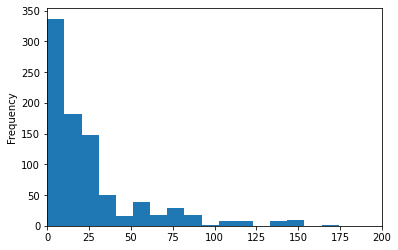

In [782]:
train_set['Fare'].plot.hist(xlim=(0,200), bins=50) 

<AxesSubplot:ylabel='Frequency'>

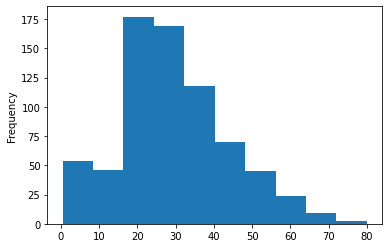

In [783]:
train_set["Age"].plot.hist()

In [784]:
import numpy as np

train_set["FareCategory"] = pd.cut(
    train_set["Fare"],
    bins=[0., 5., 15., 30., 60., np.inf],
    labels=[1, 2, 3, 4, 5]
)

train_set["AgeBucket"] = pd.cut(
    train_set["Age"],
    bins=[0., 15., 30., 45., 60., 75., np.inf],
    labels=[1, 2, 3, 4, 5, 6]
)

train_set["Name"] = train_set["Name"].apply(lambda x: x.split(",")[0])
train_set

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FareCategory,AgeBucket
PassengerId,,,,,,,,,,,,,
1,0,3,Braund,male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,2
2,1,1,Cumings,female,38.0,1,0,PC 17599,71.2833,C85,C,5,3
3,1,3,Heikkinen,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2,2
4,1,1,Futrelle,female,35.0,1,0,113803,53.1000,C123,S,4,3
5,0,3,Allen,male,35.0,0,0,373450,8.0500,NaN,S,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,Montvila,male,27.0,0,0,211536,13.0000,NaN,S,2,2
888,1,1,Graham,female,19.0,0,0,112053,30.0000,B42,S,3,2
889,0,3,Johnston,female,NaN,1,2,W./C. 6607,23.4500,NaN,S,3,NaN


In [785]:
train_data = train_set.drop(["Survived", "Age", "Ticket", "Fare", "Cabin"], axis=1) 
train_data_labels = train_set["Survived"].copy()

train_data_prepared = preprocess_pipeline.fit_transform(train_data)

In [786]:
train_data_prepared

array([[ 0.43279337, -0.47367361,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.43279337, -0.47367361,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.4745452 , -0.47367361,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.43279337,  2.00893337,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.4745452 , -0.47367361,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.4745452 , -0.47367361,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

We can start to train classifiers.

In [787]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [788]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
forest_scores = cross_val_score(forest_clf, train_data_prepared, train_data_labels, cv=10)
forest_scores.mean()

0.8260674157303372

In [789]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_scores = cross_val_score(sgd_clf, train_data_prepared, train_data_labels, cv=10)
sgd_scores.mean()

0.8102996254681649

In [790]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_scores = cross_val_score(svm_clf, train_data_prepared, train_data_labels, cv=10)
svm_scores.mean()

0.8305493133583021

In [798]:
# Looking for best parameters.
from sklearn.model_selection import GridSearchCV

param_grid = [{
    "C": [0.3, 1, 3],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": ["scale", "auto"],
    "decision_function_shape": ["ovo", "ovr"],
}]

grid_search = GridSearchCV(svm_clf, param_grid, cv=10, scoring='accuracy')
grid_search.fit(train_data_prepared, train_data_labels)

GridSearchCV(cv=10, estimator=SVC(random_state=42),
             param_grid=[{'C': [0.3, 1, 3],
                          'decision_function_shape': ['ovo', 'ovr'],
                          'gamma': ['scale', 'auto'],
                          'kernel': ['linear', 'rbf', 'poly']}],
             scoring='accuracy')

In [799]:
grid_search.best_params_

{'C': 1, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'poly'}

In [800]:
grid_search.best_score_

0.8316729088639201

In [794]:
grid_search.classes_

array([0, 1], dtype=int64)